# RTS-96 Results

It's time to convert the MATLAB code I wrote to pull RTS-96 data out of Jenny's Excel spreadsheets into Julia code.

I actually don't think I have enough time for this right now. Perhaps for the upcoming journal article.

Okay, I changed my mind. It's more important now to connect various parts of existing RTS-96 data to the temporal instanton solver.

In [1]:
include("../src/TemporalInstanton.jl")
include("../src/TrustRegionSubproblem.jl")

using TemporalInstanton, TrustRegionSubproblem

In [2]:
include("../src/tmp_inst_rts96.jl")

psData = psDataLoad()

# unpack psDL (boilerplate):
(Sb,f,t,r,x,b,Y,bustype,
Gp,Gq,Dp,Dq,Rp,Rq,
Pmax,Pmin,Qmax,Qmin,Plim,
Vg,Vceiling,Vfloor,
busIdx,N,Nr,Ng,k) = unpack_psDL(psData)

(100.0,[1,1,1,2,2,3,3,4,5,6  …  66,66,67,67,68,68,69,73,66,71],[2,3,5,4,6,9,24,9,10,10  …  69,69,68,68,71,71,70,21,47,73],[0.003,0.055,0.022,0.033,0.05,0.031,0.002,0.027,0.023,0.014  …  0.003,0.003,0.005,0.005,0.003,0.003,0.009,0.012,0.013,0.0],[0.014,0.211,0.085,0.127,0.192,0.119,0.084,0.104,0.088,0.061  …  0.026,0.026,0.04,0.04,0.022,0.022,0.068,0.097,0.104,0.009],[0.461,0.057,0.023,0.034,0.052,0.032,0.0,0.028,0.024,2.459  …  0.055,0.055,0.083,0.083,0.046,0.046,0.142,0.203,0.218,0.0],
73x73 sparse matrix with 289 Float64 entries:
	[1 ,  1]  =  87.9326
	[2 ,  1]  =  -71.4286
	[3 ,  1]  =  -4.73934
	[5 ,  1]  =  -11.7647
	[1 ,  2]  =  -71.4286
	[2 ,  2]  =  84.5109
	[4 ,  2]  =  -7.87402
	[6 ,  2]  =  -5.20833
	[1 ,  3]  =  -4.73934
	[3 ,  3]  =  25.0475
	⋮
	[60, 71]  =  -10.3093
	[61, 71]  =  -11.4943
	[68, 71]  =  -90.9091
	[71, 71]  =  223.824
	[73, 71]  =  -111.111
	[51, 72]  =  -11.9048
	[63, 72]  =  -19.2308
	[72, 72]  =  31.1355
	[21, 73]  =  -10.3093
	[71, 73]  =  -111.111
	[73

In [3]:
####### DATA ENTRY ########

# Static
Ridx = find(Rp) # Vector of renewable nodes
Y = Y # Full admittance matrix (slack not removed)
slack = 1 # Index of slack node
k = k # Conventional generator participation factors
tau = 2 # Heating constant
G0 = Gp
D = Dp
P0 = Rp
kQobj = 0 # Should always be zero; objective has no constant term
c = 10 # RHS of line temperature constraint
kQtheta = -c # Move to LHS so we have Q(z) = 0
lines = [(f[i],t[i]) for i in 1:length(f)]

line = lines[1]

(1,2)

In [28]:
# Changing
for line in lines
    display(line)
end

(1,2)

(1,3)

(1,5)

(2,4)

(2,6)

(3,9)

(3,24)

(4,9)

(5,10)

(6,10)

(7,8)

(7,27)

(8,9)

(8,10)

(9,11)

(9,12)

(10,11)

(10,12)

(11,13)

(11,14)

(12,13)

(12,23)

(13,23)

(13,39)

(14,16)

(15,16)

(15,21)

(15,21)

(15,24)

(16,17)

(16,19)

(17,18)

(17,22)

(18,21)

(18,21)

(19,20)

(19,20)

(20,23)

(20,23)

(21,22)

(23,41)

(25,26)

(25,27)

(25,29)

(26,28)

(26,30)

(27,33)

(27,48)

(28,33)

(29,34)

(30,34)

(31,32)

(32,33)

(32,34)

(33,35)

(33,36)

(34,35)

(34,36)

(35,37)

(35,38)

(36,37)

(36,47)

(37,47)

(38,40)

(39,40)

(39,45)

(39,45)

(39,48)

(40,41)

(40,43)

(41,42)

(41,46)

(42,45)

(42,45)

(43,44)

(43,44)

(44,47)

(44,47)

(45,46)

(49,50)

(49,51)

(49,53)

(50,52)

(50,54)

(51,57)

(51,72)

(52,57)

(53,58)

(54,58)

(55,56)

(56,57)

(56,58)

(57,59)

(57,60)

(58,59)

(58,60)

(59,61)

(59,62)

(60,61)

(60,71)

(61,71)

(62,64)

(63,64)

(63,69)

(63,69)

(63,72)

(64,65)

(64,67)

(65,66)

(65,70)

(66,69)

(66,69)

(67,68)

(67,68)

(68,71)

(68,71)

(69,70)

(73,21)

(66,47)

(71,73)

In [4]:
# Create instance of instanton problem:
Qobj,A,b,Qtheta = temporalInstanton(Ridx,Y,slack,k,tau,line,G0,P0,D)

G_of_x = (Qobj,0,kQobj)
Q_of_x = (Qtheta,0,kQtheta)

# Translate and rotate twice:
K_of_w,R_of_x,x_star,Rkernel,Reigvec = tr_trans_rotate(G_of_x,Q_of_x,A,b)

((
92x92 Array{Float64,2}:
 -8.70837e-16   0.0          …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0          -7.19322e-16     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0           0.0             0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0           0.0             0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0           0.0             0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0           0.0          …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0           0.0             0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0           0.0             0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0           0.0             0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0           0.0             0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0           0.0          …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0           0.0             0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0           0.0             0.0  0.0  0.0  0.0  0.0  0.0  0.0
  ⋮                          ⋱  ⋮                        ⋮       
  0.0           0.0          …  0.0  0.0  0.0  0.

In [9]:
sort(unique(diag(K_of_w[1])))

90-element Array{Float64,1}:
 -8.70837e-16
 -7.19322e-16
 -6.32302e-16
 -4.82852e-16
 -4.7215e-16 
 -3.94211e-16
 -3.40551e-16
 -3.37693e-16
 -2.42964e-16
 -2.03843e-16
 -1.36826e-16
 -1.10155e-16
 -1.00614e-16
  ⋮          
  1.0        
  1.0        
  1.0        
  1.0        
  1.0        
  1.0        
  1.0        
  1.0        
  1.0        
  1.0        
  1.0        
  1.0        

In [13]:
using PyPlot

INFO: Loading help data...


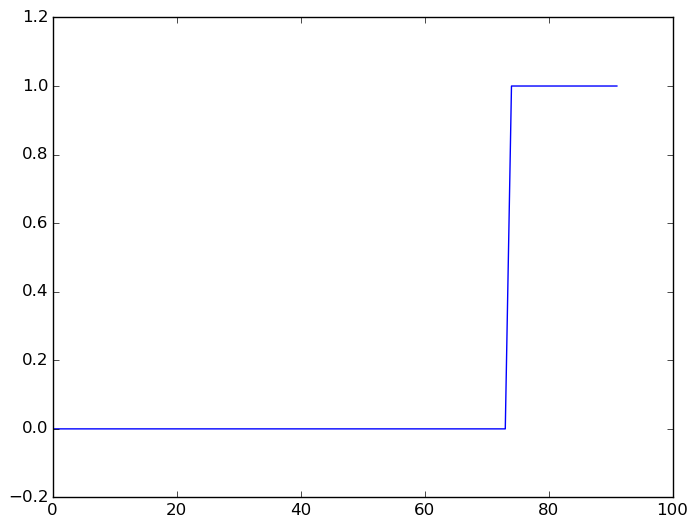

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f83dc8fbd50>

In [14]:
plot(diag(K_of_w[1]K_of_w